In [1]:
from mhkit import dolfyn as dlfn
from dolfyn.adp import api
from mhkit.dolfyn.rotate import api as ap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.fft import fft, ifft
from datetime import datetime
import xarray as xr
import scipy.interpolate as interp
import utm
from mhkit.river.io import d3d 
from os.path import abspath, dirname, join, normpath, relpath
import netCDF4
import math 
from mhkit import river

C:\Users\eabrow\Codes\Tanana_test\dolfyn\dolfyn\velocity.py:12: AccessorRegistrationWarning: registration of accessor <class 'dolfyn.velocity.Velocity'> under name 'velds' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class Velocity():


In [2]:
ds_02 = api.read('data/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0')
ds_03 = api.read('data/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0')

ds_02_03= xr.merge([ds_02,ds_03])
ds_02_03


Reading file data/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0 ...

Reading file data/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0 ...


<xarray.Dataset>
Dimensions:              (time_gps: 1180, time: 1180, beam: 4, dir: 4, range: 47, x: 4, x*: 4, earth: 3, inst: 3)
Coordinates:
  * time_gps             (time_gps) datetime64[ns] 2010-08-10T22:28:17.200000...
  * time                 (time) datetime64[ns] 2010-08-10T14:28:15.559999942 ...
  * beam                 (beam) int32 1 2 3 4
  * dir                  (dir) <U3 'X' 'Y' 'Z' 'err'
  * range                (range) float64 0.57 0.82 1.07 ... 11.57 11.82 12.07
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables: (12/36)
    number               (time) float64 3.652e+03 3.653e+03 ... 4.904e+03
    builtin_test_fail    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    c_sound              (time) float32 1.466e+03 1.466e+03 ... 1.466e+03
    depth                (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pitch                (time) float32 -0.1 -0.09 -0.21 -0.25 ... 0.2 0.07 0.56
    roll                 (time) float32 3.33 3.32 3.33 3.49 ... 2.24 2.65 2.33
    ...                   ...
    rtk_age_gps          (time_gps) float32 5.0 6.0 2.0 3.0 ... 6.0 2.0 3.0 3.0
    speed_over_grnd_gps  (time_gps) float32 0.03549 0.03395 ... 0.1096 0.1672
    dir_over_grnd_gps    (time_gps) float32 115.5 94.08 6.931 ... 160.5 182.1
    hdwtime_gps          (time_gps) datetime64[ns] 2010-08-10T14:28:15.559999...
    beam2inst_orientmat  (x, x*) float64 1.462 -1.462 0.0 ... -1.034 -1.034
    orientmat            (earth, inst, time) float64 -0.9037 -0.9025 ... 1.0 1.0
Attributes: (12/38)
    inst_make:                TRDI
    inst_type:                ADCP
    rotate_vars:              ['vel', 'vel_bt']
    has_imu:                  0
    prog_ver:                 10.16
    inst_model:               Rio Grande
    ...                       ...
    false_target_threshold:   50
    transmit_lag_m:           0.08
    bandwidth:                0
    sourceprog:               WINRIVER
    fs:                       11.11111111111111
    vel_gps_corrected:        0

In [3]:
data=utm.from_latlon(ds_02_03.latitude_gps, ds_02_03.longitude_gps, 6, 'W')
latitude=data[0]
longitude=data[1]
latitude

<xarray.DataArray (time_gps: 1180)>
array([400953.81301413, 400953.81301413, 400953.81301413, ...,
       400952.62816788, 400952.62816788, 400953.28310802])
Coordinates:
  * time_gps  (time_gps) datetime64[ns] 2010-08-10T22:28:17.200000047 ... 201...

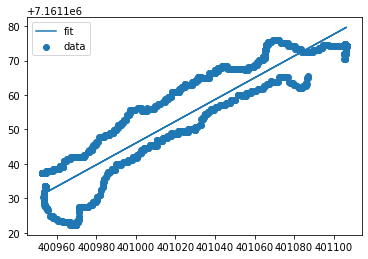

In [4]:
a,b = np.polyfit(latitude, longitude,1)
plt.scatter(latitude,longitude, label='data')
plt.plot(latitude,a*latitude+b, label= 'fit')
plt.legend()

In [5]:
# The ADCP transducers were measured to be 0.6 m from the feet of the lander
api.clean.set_range_offset(ds_02_03,0)
ds_02_03.range

<xarray.DataArray 'range' (range: 47)>
array([ 0.57,  0.82,  1.07,  1.32,  1.57,  1.82,  2.07,  2.32,  2.57,  2.82,
        3.07,  3.32,  3.57,  3.82,  4.07,  4.32,  4.57,  4.82,  5.07,  5.32,
        5.57,  5.82,  6.07,  6.32,  6.57,  6.82,  7.07,  7.32,  7.57,  7.82,
        8.07,  8.32,  8.57,  8.82,  9.07,  9.32,  9.57,  9.82, 10.07, 10.32,
       10.57, 10.82, 11.07, 11.32, 11.57, 11.82, 12.07])
Coordinates:
  * range    (range) float64 0.57 0.82 1.07 1.32 ... 11.32 11.57 11.82 12.07
Attributes:
    units:    m

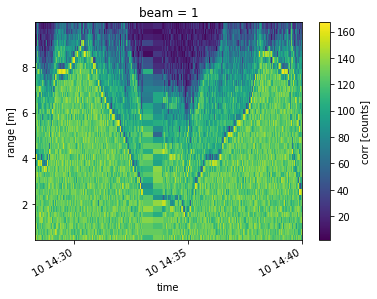

In [6]:
ds_02_03.corr.sel(beam=1, range=slice(0,10)).plot()
api.rotate2(ds_02_03, 'earth', inplace=True)
ds_02_03 = api.clean.correlation_filter(ds_02_03, thresh=40)

In [7]:
ap.set_declination(ds_02_03, 15.7, inplace=True) # 15.7 deg East for Nenana Alaska 

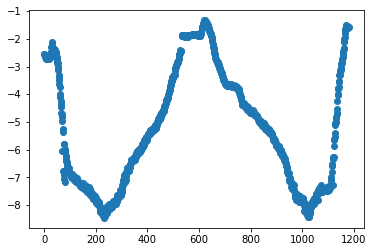

In [8]:
single_beam = ds_02_03.where(ds_02_03.dist_bt > 0 )
bottom=np.min(single_beam.dist_bt,axis=0)
plt.scatter(np.linspace(0,np.size(bottom)-1,np.size(bottom)), -bottom)

In [9]:
bottom_filter= d3d.create_points(x=bottom.to_numpy(), y=ds_02_03.range.to_numpy(), waterdepth=1)
river_bottom_filter= []

for index, row in  bottom_filter.iterrows():
    if row['x'] > row['y']: 
        filter= 1
    
    else: 
        filter= float("nan")
    river_bottom_filter= np.append(river_bottom_filter, filter)

[0, 1, 2]


In [10]:
lat= np.tile(latitude, np.size( ds_02_03.range))
long= np.tile(longitude, np.size( ds_02_03.range))
depth =np.repeat( ds_02_03.range,np.size(latitude))
Point={'latitude': lat, 'longitude': long, 'waterdepth': depth}
points=pd.DataFrame(Point)
#plt.scatter(points.latitude, points.waterdepth)
#points

In [11]:
filter_points= d3d.create_points(x=np.linspace(0,np.size(bottom)-1,np.size(bottom)), y=ds_02_03.range.to_numpy(), waterdepth=1 )

[0, 1, 2]


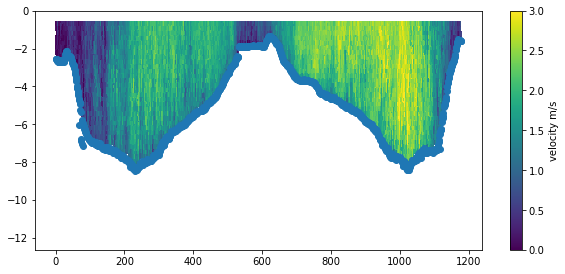

In [12]:
velocity= np.ravel(ds_02_03.vel[1, :,:])* river_bottom_filter

max_plot=0
min_plot=3

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    filter_points.x, 
    -filter_points.y, 
    velocity,
    vmin=min_plot,
    vmax=max_plot

)
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity m/s')
plt.scatter(np.linspace(0,np.size(bottom)-1,np.size(bottom)), -bottom)

In [13]:
lat_points= np.tile(latitude, np.size( ds_02_03.range))
long_points= np.tile(a*latitude+b, np.size( ds_02_03.range))
depth_points =np.repeat( ds_02_03.range,np.size(latitude))

ADCP_points={'latitude': lat_points, 'longitude': long_points, 'waterdepth': depth_points}
ADCP_points=pd.DataFrame(ADCP_points)
#plt.scatter(ADCP_points.latitude, ADCP_points_longitude)
ADCP_points

,latitude,longitude,waterdepth
0,400953.813014,7.161131e+06,0.57
1,400953.813014,7.161131e+06,0.57
2,400953.813014,7.161131e+06,0.57
3,400953.813014,7.161131e+06,0.57
4,400953.813014,7.161131e+06,0.57
...,...,...,...
55455,400952.628168,7.161131e+06,12.07
55456,400952.628168,7.161131e+06,12.07
55457,400952.628168,7.161131e+06,12.07
55458,400952.628168,7.161131e+06,12.07


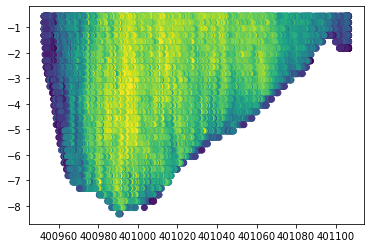

In [14]:
max_plot=3
min_plot=0

plt.scatter( ADCP_points.latitude, 
    -filter_points.y,    c=velocity,vmin=min_plot,
    vmax=max_plot )
#plt.plot(ideal_points.latitude,-bottom_avg,'k', label= 'river bottom')

In [15]:

latitude_reduced= np.linspace(np.min(latitude), np.max(latitude),100)
gps= np.array([ [lat, long] for lat, long in zip(latitude,
                            longitude)]) 
gps_points = pd.DataFrame(gps, columns= ['latitude','longitude'])
print(gps_points)
ideal= np.array([ [lat, long] for lat, long in zip(latitude_reduced,
                            a*latitude_reduced+b)]) 
ideal_points = pd.DataFrame(ideal, columns= ['latitude','longitude'])
print(ideal_points)

           latitude     longitude
0     400953.813014  7.161133e+06
1     400953.813014  7.161133e+06
2     400953.813014  7.161133e+06
3     400953.813014  7.161133e+06
4     400953.813014  7.161133e+06
...             ...           ...
1175  400952.628168  7.161137e+06
1176  400952.628168  7.161137e+06
1177  400952.628168  7.161137e+06
1178  400952.628168  7.161137e+06
1179  400953.283108  7.161137e+06

[1180 rows x 2 columns]
         latitude     longitude
0   400952.628168  7.161131e+06
1   400954.182403  7.161132e+06
2   400955.736638  7.161132e+06
3   400957.290873  7.161133e+06
4   400958.845107  7.161133e+06
..            ...           ...
95  401100.280484  7.161178e+06
96  401101.834719  7.161178e+06
97  401103.388954  7.161179e+06
98  401104.943189  7.161179e+06
99  401106.497423  7.161180e+06

[100 rows x 2 columns]


In [16]:
np.size(ds_02_03.range)

47

In [17]:
lat_points= np.tile(latitude, np.size( ds_02_03.range))
long_points= np.tile(a*latitude+b, np.size( ds_02_03.range))
depth_points =np.repeat( ds_02_03.range,np.size(latitude))

ADCP_points={'latitude': lat_points, 'longitude': long_points, 'waterdepth': depth_points}
ADCP_points=pd.DataFrame(ADCP_points)
#plt.scatter(ADCP_points.latitude, ADCP_points_longitude)
ADCP_points

,latitude,longitude,waterdepth
0,400953.813014,7.161131e+06,0.57
1,400953.813014,7.161131e+06,0.57
2,400953.813014,7.161131e+06,0.57
3,400953.813014,7.161131e+06,0.57
4,400953.813014,7.161131e+06,0.57
...,...,...,...
55455,400952.628168,7.161131e+06,12.07
55456,400952.628168,7.161131e+06,12.07
55457,400952.628168,7.161131e+06,12.07
55458,400952.628168,7.161131e+06,12.07


In [18]:
#interp points 

stat_lat = min(ADCP_points.latitude)
start_long= min(ADCP_points.longitude)

end_lat= max(ADCP_points.latitude)
end_long= min(ADCP_points.longitude)


(end_lat-stat_lat)/(math.cos(math.atan(a))*15)

10.757553827531847

In [19]:
lat_downsampeled = np.linspace(stat_lat,end_lat,10)
long_downsampeled= a*lat_downsampeled+b

In [20]:
lat_points_downsampled= np.tile(lat_downsampeled, np.size( ds_02_03.range))
long_points_downsampled= np.tile(long_downsampeled, np.size( ds_02_03.range))
depth_points_downsampled =np.repeat( ds_02_03.range,np.size(lat_downsampeled))

ADCP_points_downsamples={'latitude': lat_points_downsampled, 'longitude': long_points_downsampled, 'waterdepth': depth_points_downsampled}
ADCP_points_downsamples=pd.DataFrame(ADCP_points_downsamples)
ADCP_points_downsamples

,latitude,longitude,waterdepth
0,400952.628168,7.161131e+06,0.57
1,400969.724752,7.161136e+06,0.57
2,400986.821336,7.161142e+06,0.57
3,401003.917920,7.161147e+06,0.57
4,401021.014504,7.161153e+06,0.57
...,...,...,...
465,401038.111088,7.161158e+06,12.07
466,401055.207672,7.161163e+06,12.07
467,401072.304256,7.161169e+06,12.07
468,401089.400839,7.161174e+06,12.07


In [21]:
points['velocity']=velocity 
points

,latitude,longitude,waterdepth,velocity
0,400953.813014,7.161133e+06,0.57,0.214233
1,400953.813014,7.161133e+06,0.57,0.079026
2,400953.813014,7.161133e+06,0.57,0.129486
3,400953.813014,7.161133e+06,0.57,0.519561
4,400953.813014,7.161133e+06,0.57,0.393507
...,...,...,...,...
55455,400952.628168,7.161137e+06,12.07,NaN
55456,400952.628168,7.161137e+06,12.07,NaN
55457,400952.628168,7.161137e+06,12.07,NaN
55458,400952.628168,7.161137e+06,12.07,NaN


In [22]:
points= points.dropna()

In [23]:
points[['latitude','longitude','waterdepth']]

,latitude,longitude,waterdepth
0,400953.813014,7.161133e+06,0.57
1,400953.813014,7.161133e+06,0.57
2,400953.813014,7.161133e+06,0.57
3,400953.813014,7.161133e+06,0.57
4,400953.813014,7.161133e+06,0.57
...,...,...,...
36427,400989.066656,7.161150e+06,8.07
36428,400989.066656,7.161150e+06,8.07
37600,400991.049338,7.161150e+06,8.32
37601,400990.394398,7.161150e+06,8.32


In [24]:
# Project velocity onto ideal tansect 
ADCP= pd.DataFrame()
#ADCP['East']= interp.griddata(points,np.ravel(ds_02_03.vel[0,:,:]),ADCP_points)
ADCP['North']= interp.griddata(points[['latitude','longitude','waterdepth']],points['velocity'],ADCP_points, method='linear', fill_value=0)
#ADCP['Vertical']= interp.griddata(points,np.ravel(ds_02_03.vel[2,:,:]),ADCP_points)

In [25]:
ideal= np.array([ [lat, long] for lat, long in zip(latitude,
                            a*latitude+b)]) 
ideal_sampled_points = pd.DataFrame(ideal, columns= ['latitude','longitude'])

bottom_avg= interp.griddata(gps_points,bottom,ideal_sampled_points, method='linear')
bottom_filter = d3d.create_points(x=bottom_avg, y=ds_02_03.range.to_numpy(), waterdepth=1)
river_bottom_filter= []

for index, row in  bottom_filter.iterrows():
    if row['x'] > row['y']: 
        filter= 1
    
    else: 
        filter= float("nan")
    river_bottom_filter= np.append(river_bottom_filter, filter)
np.size(river_bottom_filter)

[0, 1, 2]


55460

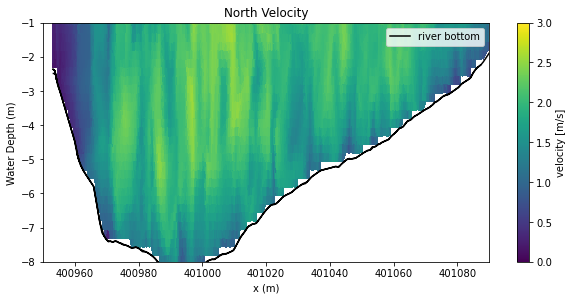

In [26]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_points.latitude, 
    -ADCP_points.waterdepth, 
     ADCP.North*river_bottom_filter,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('North Velocity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8,-1])
plt.xlim([400950,401090])
plt.plot(ideal_sampled_points.latitude,-bottom_avg,'k', label= 'river bottom')
plt.legend()

In [27]:
lat_downsampeled = np.linspace(stat_lat,end_lat,10)
long_downsampeled= a*lat_downsampeled+b

ideal_downsampeled= np.array([ [lat, long] for lat, long in zip(lat_downsampeled,
                            a*lat_downsampeled+b)]) 
ideal_sampled_points_downsampled = pd.DataFrame(ideal_downsampeled, columns= ['latitude','longitude'])

bottom_avg_downsampled= interp.griddata(gps_points, bottom, ideal_sampled_points_downsampled, method='linear')
bottom_filter_downsampled = d3d.create_points(x=bottom_avg_downsampled, y=ds_02_03.range.to_numpy(), waterdepth=1)
river_bottom_filter_downsampled= []

for index, row in  bottom_filter_downsampled.iterrows():
    if row['x'] > row['y']: 
        filter= 1
    
    else: 
        filter= float("nan")
    river_bottom_filter_downsampled= np.append(river_bottom_filter_downsampled, filter)

[0, 1, 2]


In [28]:
ADCP_downsamples= pd.DataFrame()
ADCP_downsamples['North']= interp.griddata(points[['latitude','longitude','waterdepth']],points['velocity'],ADCP_points_downsamples, method='linear', fill_value=0)

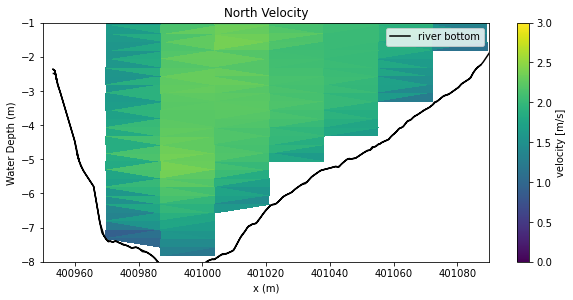

In [29]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_points_downsamples.latitude, 
    -ADCP_points_downsamples.waterdepth, 
     ADCP_downsamples.North*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('North Velocity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8,-1])
plt.xlim([400950,401090])
plt.plot(ideal_sampled_points.latitude,-bottom_avg,'k', label= 'river bottom')
plt.legend()

In [101]:
x= lat_downsampeled
y= ds_02_03.range
xv, yv = np.meshgrid(x, y)

In [116]:
y[46]-y[45]

<xarray.DataArray 'range' ()>
array(0.25)

In [113]:
x[9]-x[8]

17.09658395271981

In [98]:
xv

array([[400952.62816788, 400969.72475183, 400986.82133578,
        401003.91791973, 401021.01450369, 401038.11108764,
        401055.20767159, 401072.30425554, 401089.4008395 ,
        401106.49742345],
       [400952.62816788, 400969.72475183, 400986.82133578,
        401003.91791973, 401021.01450369, 401038.11108764,
        401055.20767159, 401072.30425554, 401089.4008395 ,
        401106.49742345],
       [400952.62816788, 400969.72475183, 400986.82133578,
        401003.91791973, 401021.01450369, 401038.11108764,
        401055.20767159, 401072.30425554, 401089.4008395 ,
        401106.49742345],
       [400952.62816788, 400969.72475183, 400986.82133578,
        401003.91791973, 401021.01450369, 401038.11108764,
        401055.20767159, 401072.30425554, 401089.4008395 ,
        401106.49742345],
       [400952.62816788, 400969.72475183, 400986.82133578,
        401003.91791973, 401021.01450369, 401038.11108764,
        401055.20767159, 401072.30425554, 401089.4008395 ,
        401

In [91]:
 ADCP_downsamples.North.to_numpy()

(470,)

In [118]:
np.reshape( ADCP_downsamples.North.to_numpy(), (47,10))

AttributeError: 'numpy.ndarray' object has no attribute 'isnan'

In [95]:
xv.shape

(47, 10)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

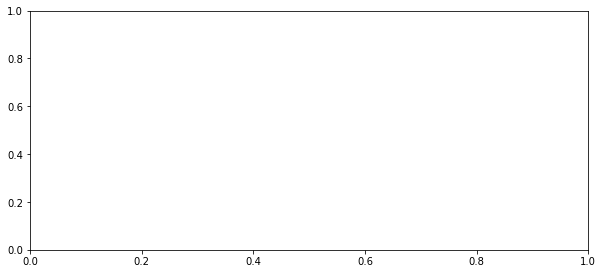

In [121]:
x= lat_downsampeled
y= ds_02_03.range*-1
z=np.reshape(ADCP_downsamples.North.to_numpy(), (47,10))

max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.contourf(
    [x,y], 
    z,
    levels=[0,1,2,3]
)

plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('North Velocity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
#plt.ylim([-8,-1])
#plt.xlim([400950,401090])
#plt.plot(ideal_sampled_points.latitude,-bottom_avg,'k', label= 'river bottom')
#plt.legend()

In [ ]:
# Use the requests method to obtain 10 years of daily discharge data
#data = river.io.usgs.request_usgs_data(station="15515500",
#                            parameter='00065',
#                            start_date='2010-08-10',
#                            end_date='2010-08-10',
#                            data_type='Instantaneous')

## Print data
#print(data)

In [ ]:
# Simulated data
# Downloading Data
d3d_data = netCDF4.Dataset('data/tanana81010_final_map.nc')

In [ ]:
# Printing variable and description
for var in d3d_data.variables.keys():
    try: 
        d3d_data[var].long_name
    except:
        print(f'"{var}"')        
    else:
        print(f'"{var}": {d3d_data[var].long_name}')

In [ ]:
ADCP_points_downsamples_xy= ADCP_points_downsamples.rename(columns={"latitude": "x", "longitude": "y"})


In [ ]:
variables= ['ucy']
D3d= d3d.variable_interpolation(d3d_data, variables, points= ADCP_points_downsamples_xy)

In [ ]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    D3d.ucy*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot,
    #shading='gouraud'
    alpha=1
)
#*river_bottom_filter_downsampled

plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('Velocity in the Y direction')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8,0])
plt.xlim([400960,401090])
plt.plot(ideal_sampled_points.latitude,-bottom_avg,'k', label= 'river bottom')
plt.legend()

In [ ]:
# L1

#north 
L1_north= abs(ADCP_downsamples.North-D3d.ucy)/ADCP_downsamples.North


#East 
#L1_east= abs(ADCP.East-D3D.ucx) / ADCP.East/

#Vertical 
#L1_vert= abs(ADCP.Vertical-D3D.ucz) / ADCP.Vertical


MAE= np.sum(L1_north[L1_north< 1000])/len(L1_north[L1_north< 1000 ])
MAE

In [ ]:
max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L1 = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    L1_north*river_bottom_filter_downsampled,
        vmin=min_plot,
    vmax=max_plot
)

plt.xlim([400960,401090])
plt.ylim([-8,-1])
plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('L1 error between Delft3D and ADCP data for North velocity')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('L1 velocity error')
plt.plot(ideal_sampled_points.latitude,-bottom_avg,'k', label= 'river bottom')
plt.legend()

In [ ]:
# L2 

L2_north= ((ADCP_downsamples.North-D3d.ucy)/ADCP_downsamples.North)**2

##East 
#(ADCP.East-D3D.ucx)^2 / ADCP.East

##Vertical 
#(ADCP.Vertical-D3D.ucz)^2 / ADCP.Vertical


RMS=np.sum(L2_north[L2_north< 1000])/np.size(L2_north[L2_north< 1000])

print(RMS)

max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L2 = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    L2_north*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlim([400960,401090])
plt.ylim([-8,-1])
plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('L2 error between Delft3D and ADCP data for North velocity')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('L2 velocity error')
plt.plot(ideal_sampled_points.latitude,-bottom_avg,'k', label= 'river bottom')
plt.legend()

In [ ]:
# L inf

L_inf=np.nanmax(L1_north[L1_north< 1000 ])
L_inf

#find location 
#is this the same max of L2? /
#error of downsampled data 